In [12]:
import mlrose_hiive as mh
from mlrose_hiive.runners import SARunner, GARunner, MIMICRunner, RHCRunner, NNGSRunner
from mlrose_hiive import QueensGenerator, QueensOpt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [13]:
def model_evaluation(y_test, y_pred):
   accuracy = metrics.accuracy_score(y_test, y_pred)
   f1 = metrics.f1_score(y_test, y_pred)
   return accuracy, f1

In [14]:
cars = pd.read_csv('data/car.data', names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'target'])
cars['target'] = cars['target'].apply(lambda x: 0 if x == 'unacc' else 1)
Y = cars['target']

skencoder = OneHotEncoder(drop='first',sparse_output=False)
skencoder.set_output(transform="pandas")
ohe_cars = skencoder.fit_transform(cars.loc[:,['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']])
ohe_cars['target'] = Y
cars_x = ohe_cars.loc[:, ohe_cars.columns != 'target']
cars_y = ohe_cars['target']

X_train, X_test, y_train, y_test = train_test_split(cars_x, cars_y, test_size = 0.2, random_state=0)



In [48]:
nn_rhc = mh.NeuralNetwork(hidden_nodes = [180], activation = 'relu', \
                                 algorithm = 'random_hill_climb', max_iters = 500, \
                                 bias = True, is_classifier = True, learning_rate = 0.001, \
                                 early_stopping = False, clip_max = 5, max_attempts = 100, \
                                 random_state = 0, curve=True)

In [49]:
nn_rhc.fit(X_train, y_train)

NeuralNetwork(clip_max=5, curve=True, hidden_nodes=[180], learning_rate=0.001,
              max_attempts=100, max_iters=500, random_state=0)

In [15]:
params_rhc ={
    'max_iters': [500],
    'activation': [mh.relu],
    'restarts': [10,20,30],
}

nn_rhc = NNGSRunner(
    x_train=X_train,
    y_train=y_train,
    x_test=X_test,
    y_test=y_test,
    experiment_name='nn_test_rhc',
    algorithm=mh.algorithms.rhc.random_hill_climb,
    grid_search_parameters=params_rhc,
    iteration_list=2 ** np.arange(11),
    hidden_layer_sizes=[[180]],
    early_stopping=False,
    max_attempts=100,
    seed=0,
    n_jobs=5,
    output_directory=None
)

run_stats_rhc, curves_rhc, cv_results_rhc, grid_search_cv_rhc = nn_rhc.run()

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [28]:
grid_search_cv_rhc.cv_results_

{'mean_fit_time': array([ 47.49707522, 106.41193542, 187.80728598]),
 'std_fit_time': array([0.16024384, 0.39202142, 0.45079135]),
 'mean_score_time': array([0.00150137, 0.0018003 , 0.00180025]),
 'std_score_time': array([0.00063414, 0.0004003 , 0.00039992]),
 'param_activation': masked_array(data=[<function relu at 0x00000179500A2280>,
                    <function relu at 0x00000179500A2280>,
                    <function relu at 0x00000179500A2280>],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[list([180]), list([180]), list([180])],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_iters': masked_array(data=[500, 500, 500],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_restarts': masked_array(data=[10, 20, 30],
              mask=[False, False, False],
        fill_value='?',


In [33]:
validation_rhc = [
    grid_search_cv_rhc.cv_results_['split0_test_score'].mean(),
    grid_search_cv_rhc.cv_results_['split1_test_score'].mean(),
    grid_search_cv_rhc.cv_results_['split2_test_score'].mean(),
    grid_search_cv_rhc.cv_results_['split3_test_score'].mean(),
    grid_search_cv_rhc.cv_results_['split4_test_score'].mean()
]

train_rhc = [
    grid_search_cv_rhc.cv_results_['split0_train_score'].mean(),
    grid_search_cv_rhc.cv_results_['split1_train_score'].mean(),
    grid_search_cv_rhc.cv_results_['split2_train_score'].mean(),
    grid_search_cv_rhc.cv_results_['split3_train_score'].mean(),
    grid_search_cv_rhc.cv_results_['split4_train_score'].mean()
]

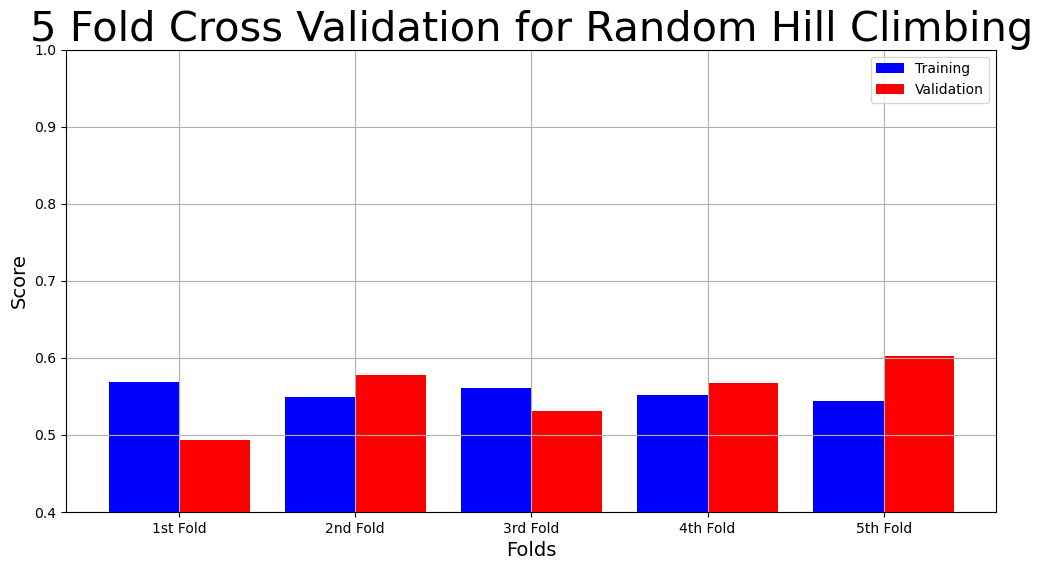

In [31]:
plt.figure(figsize=(12,6))
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
X_axis = np.arange(len(labels))
ax = plt.gca()
plt.ylim(0.40000, 1)
plt.bar(X_axis-0.2, train_rhc, 0.4, color='blue', label='Training')
plt.bar(X_axis+0.2, validation_rhc, 0.4, color='red', label='Validation')
plt.title('5 Fold Cross Validation for Random Hill Climbing', fontsize=30)
plt.xticks(X_axis, labels)
plt.xlabel('Folds', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [24]:
cv_results_rhc

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_max_iters,param_restarts,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,46.331774,0.162126,0.0018,0.00040,relu,[180],500,10,{'activation': <function relu at 0x000001172CC...,0.493541,...,0.553984,0.042279,2,0.570193,0.545135,0.560848,0.551413,0.539496,0.553417,0.010982
1,106.111942,0.209169,0.0014,0.00049,relu,[180],500,20,{'activation': <function relu at 0x000001172CC...,0.491802,...,0.558059,0.037689,1,0.572028,0.552383,0.562102,0.554679,0.551558,0.558550,0.007697
2,185.360166,0.197668,0.0014,0.00049,relu,[180],500,30,{'activation': <function relu at 0x000001172CC...,0.494411,...,0.550593,0.035575,3,0.562510,0.549608,0.558376,0.548146,0.541109,0.551950,0.007619


In [18]:
curves_rhc

,Iteration,Time,Fitness,FEvals,max_iters,restarts,init_state,algorithm,activation,bias,early_stopping,clip_max,hidden_layer_sizes,learning_rate_init,max_attempts,current_restart
0,0,0.009810,2.729372,1.0,500,20,"[0.0976270078546495, 0.43037873274483895, 0.20...",rhc,relu,True,False,1.000000e+10,[180],0.1,500,0
1,1,0.022320,2.729372,2.0,500,20,"[0.0976270078546495, 0.43037873274483895, 0.20...",rhc,relu,True,False,1.000000e+10,[180],0.1,500,0
2,2,0.033986,2.729372,3.0,500,20,"[0.0976270078546495, 0.43037873274483895, 0.20...",rhc,relu,True,False,1.000000e+10,[180],0.1,500,0
3,3,0.043952,2.729372,4.0,500,20,"[0.0976270078546495, 0.43037873274483895, 0.20...",rhc,relu,True,False,1.000000e+10,[180],0.1,500,0
4,4,0.053420,2.727414,6.0,500,20,"[0.0976270078546495, 0.43037873274483895, 0.20...",rhc,relu,True,False,1.000000e+10,[180],0.1,500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10496,496,3.260063,1.660393,15734.0,500,20,"[0.0976270078546495, 0.43037873274483895, 0.20...",rhc,relu,True,False,1.000000e+10,[180],0.1,500,20
10497,497,3.268233,1.659977,15736.0,500,20,"[0.0976270078546495, 0.43037873274483895, 0.20...",rhc,relu,True,False,1.000000e+10,[180],0.1,500,20
10498,498,3.272947,1.659087,15738.0,500,20,"[0.0976270078546495, 0.43037873274483895, 0.20...",rhc,relu,True,False,1.000000e+10,[180],0.1,500,20
10499,499,3.282385,1.659087,15739.0,500,20,"[0.0976270078546495, 0.43037873274483895, 0.20...",rhc,relu,True,False,1.000000e+10,[180],0.1,500,20


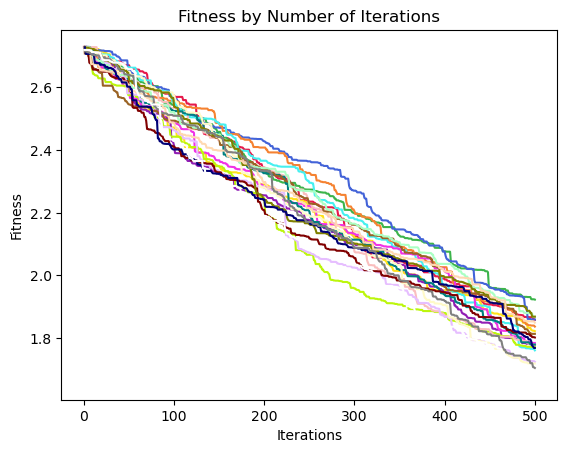

In [51]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#e6194b']

fig, ax = plt.subplots()
for i in np.arange(0,21,1):
    ax.plot(curves_rhc['Iteration'][curves_rhc['current_restart']==i], curves_rhc['Fitness'][curves_rhc['current_restart']==i],
        label = f"restart = {i}", color = colors[i])

plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('Fitness by Number of Iterations')
plt.show()

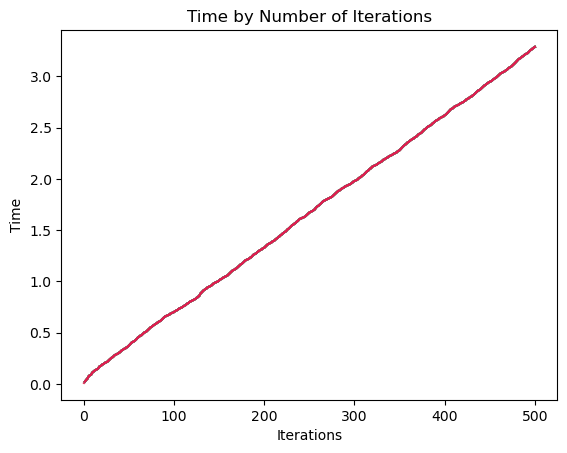

In [54]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#e6194b', '#e6194b']

fig, ax = plt.subplots()
for i in np.arange(0,21,1):
    ax.plot(curves_rhc['Iteration'][curves_rhc['current_restart']==i], curves_rhc['Time'][curves_rhc['current_restart']==i],
        label = f"restart = {i}", color = colors[i])

plt.xlabel('Iterations')
plt.ylabel('Time')
plt.title('Time by Number of Iterations')
plt.show()

In [23]:
y_pred_rhc = grid_search_cv_rhc.predict(X_test)
acc_rhc, f1_rhc = model_evaluation(y_test, y_pred_rhc)
print('Accuracy: ', acc_rhc)
print('F1: ', f1_rhc)

Accuracy:  0.569364161849711
F1:  0.46209386281588444


In [35]:
params_sa = {
    'max_iters': [500],
    'activation': [mh.relu],
    'temperatures': [2.0, 1.5, 1.0, 0.75, 0.66, 0.5, 0.1]
}

nn_sa = NNGSRunner(
    x_train=X_train,
    y_train=y_train,
    x_test=X_test,
    y_test=y_test,
    experiment_name='nn_test_sa',
    algorithm=mh.algorithms.sa.simulated_annealing,
    grid_search_parameters=params_sa,
    iteration_list=2 ** np.arange(11),
    hidden_layer_sizes=[[180]],
    early_stopping=False,
    max_attempts=100,
    seed=0,
    n_jobs=5,
    output_directory=None
)

run_stats_sa, curves_sa, cv_results_sa, grid_search_cv_sa = nn_sa.run()


Fitting 5 folds for each of 7 candidates, totalling 35 fits


In [36]:
validation_sa = [
    grid_search_cv_sa.cv_results_['split0_test_score'].mean(),
    grid_search_cv_sa.cv_results_['split1_test_score'].mean(),
    grid_search_cv_sa.cv_results_['split2_test_score'].mean(),
    grid_search_cv_sa.cv_results_['split3_test_score'].mean(),
    grid_search_cv_sa.cv_results_['split4_test_score'].mean()
]

train_sa = [
    grid_search_cv_sa.cv_results_['split0_train_score'].mean(),
    grid_search_cv_sa.cv_results_['split1_train_score'].mean(),
    grid_search_cv_sa.cv_results_['split2_train_score'].mean(),
    grid_search_cv_sa.cv_results_['split3_train_score'].mean(),
    grid_search_cv_sa.cv_results_['split4_train_score'].mean()
]

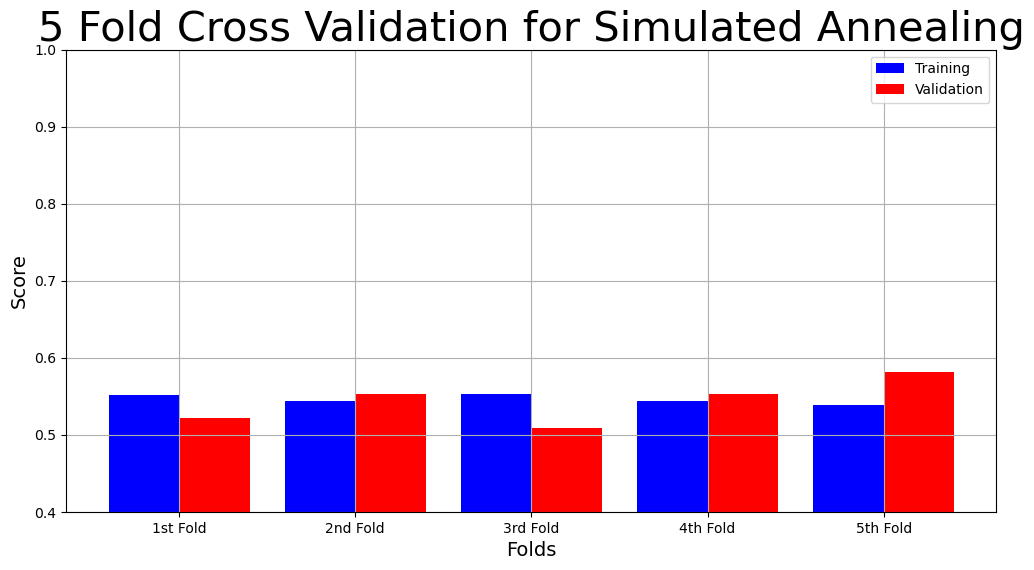

In [44]:
plt.figure(figsize=(12,6))
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
X_axis = np.arange(len(labels))
ax = plt.gca()
plt.ylim(0.40000, 1)
plt.bar(X_axis-0.2, train_sa, 0.4, color='blue', label='Training')
plt.bar(X_axis+0.2, validation_sa, 0.4, color='red', label='Validation')
plt.title('5 Fold Cross Validation for Simulated Annealing', fontsize=30)
plt.xticks(X_axis, labels)
plt.xlabel('Folds', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [40]:
curves_sa

,Iteration,Time,Fitness,FEvals,max_iters,temperatures,init_state,algorithm,activation,bias,early_stopping,clip_max,hidden_layer_sizes,learning_rate_init,max_attempts
0,0,0.010233,2.729372,2.0,500,2.0,"[0.0976270078546495, 0.43037873274483895, 0.20...",sa,relu,True,False,1.000000e+10,[180],0.1,500
1,1,0.023299,2.729372,3.0,500,2.0,"[0.0976270078546495, 0.43037873274483895, 0.20...",sa,relu,True,False,1.000000e+10,[180],0.1,500
2,2,0.040176,2.743474,5.0,500,2.0,"[0.0976270078546495, 0.43037873274483895, 0.20...",sa,relu,True,False,1.000000e+10,[180],0.1,500
3,3,0.057456,2.742978,7.0,500,2.0,"[0.0976270078546495, 0.43037873274483895, 0.20...",sa,relu,True,False,1.000000e+10,[180],0.1,500
4,4,0.066603,2.741571,9.0,500,2.0,"[0.0976270078546495, 0.43037873274483895, 0.20...",sa,relu,True,False,1.000000e+10,[180],0.1,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,496,4.033326,2.565654,973.0,500,2.0,"[0.0976270078546495, 0.43037873274483895, 0.20...",sa,relu,True,False,1.000000e+10,[180],0.1,500
497,497,4.037895,2.565654,974.0,500,2.0,"[0.0976270078546495, 0.43037873274483895, 0.20...",sa,relu,True,False,1.000000e+10,[180],0.1,500
498,498,4.046895,2.563671,976.0,500,2.0,"[0.0976270078546495, 0.43037873274483895, 0.20...",sa,relu,True,False,1.000000e+10,[180],0.1,500
499,499,4.056132,2.562523,978.0,500,2.0,"[0.0976270078546495, 0.43037873274483895, 0.20...",sa,relu,True,False,1.000000e+10,[180],0.1,500


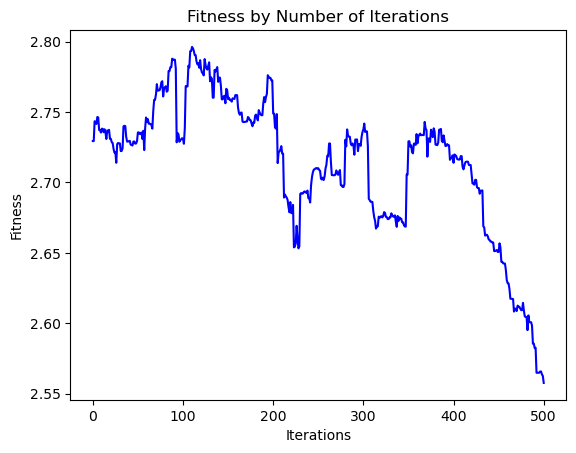

In [42]:
fig, ax = plt.subplots()
ax.plot(curves_sa['Iteration'], curves_sa['Fitness'],
    label = "Fitness", color = 'blue')

plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('Fitness by Number of Iterations')
plt.show()

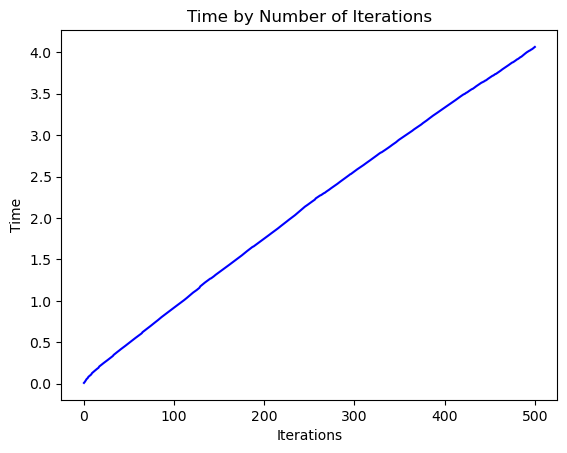

In [55]:
fig, ax = plt.subplots()
ax.plot(curves_sa['Iteration'], curves_sa['Time'],
    label = "Time", color = 'blue')

plt.xlabel('Iterations')
plt.ylabel('Time')
plt.title('Time by Number of Iterations')
plt.show()

In [26]:
y_pred_sa = grid_search_cv_sa.predict(X_test)
acc_sa, f1_sa = model_evaluation(y_test, y_pred_sa)
print('Accuracy: ', acc_sa)
print('F1: ', f1_sa)

Accuracy:  0.4682080924855491
F1:  0.48022598870056493


In [4]:
params_ga = {
    'max_iters': [500],
    'activation': [mh.relu],
    'population_sizes': [150],
    'mutation_rates': [0.05]
}

nn_ga = NNGSRunner(
    x_train=X_train,
    y_train=y_train,
    x_test=X_test,
    y_test=y_test,
    experiment_name='nn_test_ga',
    algorithm=mh.algorithms.ga.genetic_alg,
    grid_search_parameters=params_ga,
    iteration_list=2 ** np.arange(11),
    hidden_layer_sizes=[[180]],
    early_stopping=False,
    max_attempts=100,
    seed=0,
    n_jobs=5,
    output_directory=None
)

run_stats_ga, curves_ga, cv_results_ga, grid_search_cv_ga = nn_ga.run()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [43]:
validation_ga = [
    grid_search_cv_ga.cv_results_['split0_test_score'].mean(),
    grid_search_cv_ga.cv_results_['split1_test_score'].mean(),
    grid_search_cv_ga.cv_results_['split2_test_score'].mean(),
    grid_search_cv_ga.cv_results_['split3_test_score'].mean(),
    grid_search_cv_ga.cv_results_['split4_test_score'].mean()
]

train_ga = [
    grid_search_cv_ga.cv_results_['split0_train_score'].mean(),
    grid_search_cv_ga.cv_results_['split1_train_score'].mean(),
    grid_search_cv_ga.cv_results_['split2_train_score'].mean(),
    grid_search_cv_ga.cv_results_['split3_train_score'].mean(),
    grid_search_cv_ga.cv_results_['split4_train_score'].mean()
]

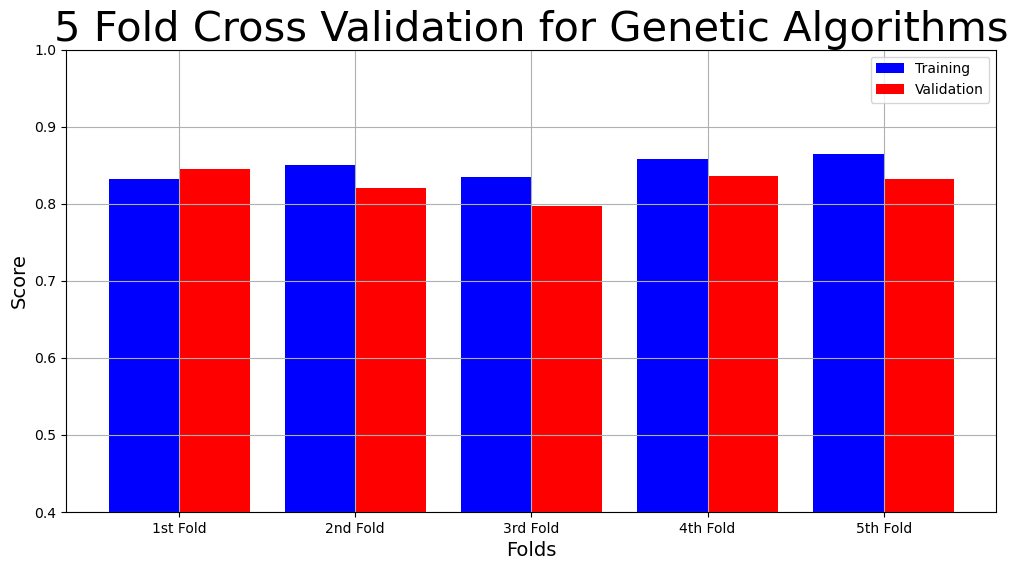

In [45]:
plt.figure(figsize=(12,6))
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
X_axis = np.arange(len(labels))
ax = plt.gca()
plt.ylim(0.40000, 1)
plt.bar(X_axis-0.2, train_ga, 0.4, color='blue', label='Training')
plt.bar(X_axis+0.2, validation_ga, 0.4, color='red', label='Validation')
plt.title('5 Fold Cross Validation for Genetic Algorithms', fontsize=30)
plt.xticks(X_axis, labels)
plt.xlabel('Folds', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [46]:
curves_ga

,Iteration,Time,Fitness,FEvals,max_iters,population_sizes,mutation_rates,init_state,algorithm,activation,bias,early_stopping,clip_max,hidden_layer_sizes,learning_rate_init,max_attempts
0,0,0.807192,9.858539,201.0,500,150,0.05,"[0.0976270078546495, 0.43037873274483895, 0.20...",ga,relu,True,False,1.000000e+10,[180],0.1,500
1,1,1.719880,9.858539,403.0,500,150,0.05,"[0.0976270078546495, 0.43037873274483895, 0.20...",ga,relu,True,False,1.000000e+10,[180],0.1,500
2,2,2.634079,8.554500,605.0,500,150,0.05,"[0.0976270078546495, 0.43037873274483895, 0.20...",ga,relu,True,False,1.000000e+10,[180],0.1,500
3,3,3.548537,8.371934,807.0,500,150,0.05,"[0.0976270078546495, 0.43037873274483895, 0.20...",ga,relu,True,False,1.000000e+10,[180],0.1,500
4,4,4.483304,8.371934,1008.0,500,150,0.05,"[0.0976270078546495, 0.43037873274483895, 0.20...",ga,relu,True,False,1.000000e+10,[180],0.1,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,496,444.413760,4.251169,99911.0,500,150,0.05,"[0.0976270078546495, 0.43037873274483895, 0.20...",ga,relu,True,False,1.000000e+10,[180],0.1,500
497,497,445.333698,4.251169,100112.0,500,150,0.05,"[0.0976270078546495, 0.43037873274483895, 0.20...",ga,relu,True,False,1.000000e+10,[180],0.1,500
498,498,446.224228,4.251169,100313.0,500,150,0.05,"[0.0976270078546495, 0.43037873274483895, 0.20...",ga,relu,True,False,1.000000e+10,[180],0.1,500
499,499,447.086375,4.251169,100514.0,500,150,0.05,"[0.0976270078546495, 0.43037873274483895, 0.20...",ga,relu,True,False,1.000000e+10,[180],0.1,500


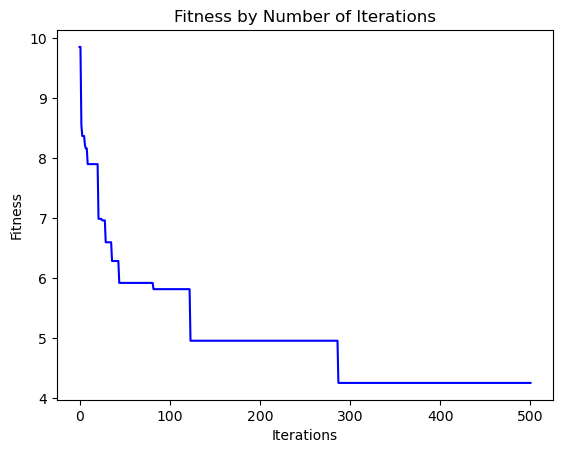

In [47]:
fig, ax = plt.subplots()
ax.plot(curves_ga['Iteration'], curves_ga['Fitness'],
    label = "Fitness", color = 'blue')

plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('Fitness by Number of Iterations')
plt.show()

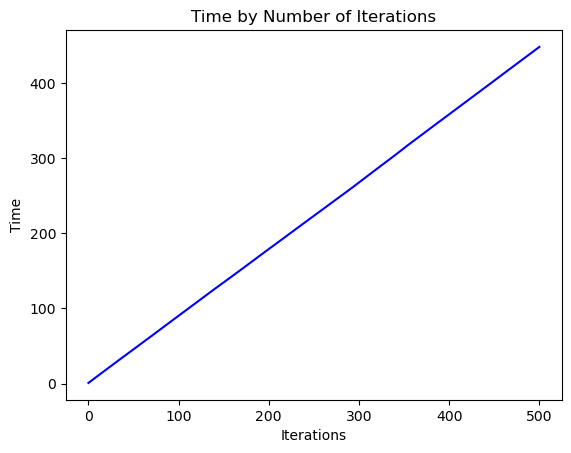

In [56]:
fig, ax = plt.subplots()
ax.plot(curves_ga['Iteration'], curves_ga['Time'],
    label = "Time", color = 'blue')

plt.xlabel('Iterations')
plt.ylabel('Time')
plt.title('Time by Number of Iterations')
plt.show()

In [5]:
y_pred_ga = grid_search_cv_ga.predict(X_test)
acc_ga, f1_ga = model_evaluation(y_test, y_pred_ga)
print('Accuracy: ', acc_ga)
print('F1: ', f1_ga)

Accuracy:  0.8728323699421965
F1:  0.8


In [19]:
curves_ga

,Iteration,Time,Fitness,FEvals,max_iters,population_sizes,mutation_rates,init_state,algorithm,activation,bias,early_stopping,clip_max,hidden_layer_sizes,learning_rate_init,max_attempts
0,0,0.807192,9.858539,201.0,500,150,0.05,"[0.0976270078546495, 0.43037873274483895, 0.20...",ga,relu,True,False,1.000000e+10,[180],0.1,500
1,1,1.719880,9.858539,403.0,500,150,0.05,"[0.0976270078546495, 0.43037873274483895, 0.20...",ga,relu,True,False,1.000000e+10,[180],0.1,500
2,2,2.634079,8.554500,605.0,500,150,0.05,"[0.0976270078546495, 0.43037873274483895, 0.20...",ga,relu,True,False,1.000000e+10,[180],0.1,500
3,3,3.548537,8.371934,807.0,500,150,0.05,"[0.0976270078546495, 0.43037873274483895, 0.20...",ga,relu,True,False,1.000000e+10,[180],0.1,500
4,4,4.483304,8.371934,1008.0,500,150,0.05,"[0.0976270078546495, 0.43037873274483895, 0.20...",ga,relu,True,False,1.000000e+10,[180],0.1,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,496,444.413760,4.251169,99911.0,500,150,0.05,"[0.0976270078546495, 0.43037873274483895, 0.20...",ga,relu,True,False,1.000000e+10,[180],0.1,500
497,497,445.333698,4.251169,100112.0,500,150,0.05,"[0.0976270078546495, 0.43037873274483895, 0.20...",ga,relu,True,False,1.000000e+10,[180],0.1,500
498,498,446.224228,4.251169,100313.0,500,150,0.05,"[0.0976270078546495, 0.43037873274483895, 0.20...",ga,relu,True,False,1.000000e+10,[180],0.1,500
499,499,447.086375,4.251169,100514.0,500,150,0.05,"[0.0976270078546495, 0.43037873274483895, 0.20...",ga,relu,True,False,1.000000e+10,[180],0.1,500
